In [1]:
from collections import Counter, OrderedDict
from itertools import product
import random
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform

%matplotlib inline

In [2]:
# ad-hoc imports
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
from utils.adjust_text import adjust_text

In [3]:
# load data (hack)
sys.path.append(os.path.abspath(os.path.join('..', 'data', 'robomission')))
from tasks_2017_09_25 import tasks

In [4]:
# helper functions

def get_letters(task):
    """Return all letters (= objects) in the setting of a task"""
    letters = Counter()
    fields = task.setting['fields']
    for row in fields:
        for _background, objects in row:
            letters.update(canonize(objects))
    return letters


def get_special_color_count(task):
    fields = task.setting['fields']
    colors = set()
    for row in fields:
        for background, _objects in row:
            colors.add(background)
    return len(colors) - 2  # don't count black and blue


def canonize(letters):
    # canonize wormhole names
    letters = ['W' if letter in 'XYZ' else letter for letter in letters]
    return letters


def _get_all_letters():
    """Return set of all letters appearing in at least one task
    
    Ignores letters appearing in all tasks (they are not informative)
    """
    letter_sets = [set(get_letters(task)) for task in tasks]
    letters_in_some_tasks = set.union(*letter_sets)
    letters_in_all_tasks = set.intersection(*letter_sets)
    return letters_in_some_tasks - letters_in_all_tasks

ALL_LETTERS = list(sorted(_get_all_letters()))



def _get_tokens_counts(ast):
    """Return a counter of all tokens (~ blockly blocks) in given RoboAST
    """
    # TODO: unhack, allow for and/or
    if not ast:
        return Counter()
    if 'statement' in ast:
        return _get_tokens_counts(ast['statement'])
    tokens = Counter([ast['head']])
    if 'test' in ast:
        tokens[ast['test']['head']] += 1
    next_statements = ast['body'] if 'body' in ast else []
    if 'orelse' in ast and ast['orelse'] is not None:
        next_statements.append(ast['orelse'])
    for statement in next_statements:
        tokens.update(_get_tokens_counts(statement))
    return tokens


def get_solution_tokens_counts(task):
    return _get_tokens_counts(task.solution)


def _get_all_solution_tokens():
    """Return set of all tokens appearing in at least one task
    
    Ignores tokens appearing in all tasks (they are not informative)
    """
    token_sets = [set(get_solution_tokens_counts(task)) for task in tasks]
    tokens_in_some_tasks = set.union(*token_sets)
    tokens_in_all_tasks = set.intersection(*token_sets)
    return tokens_in_some_tasks - tokens_in_all_tasks

ALL_TOKENS = _get_all_solution_tokens()


def get_level(task, norm=True):
    levels = {
        'moves': 1,
        'world': 2,
        'repeat': 3,
        'while': 4,
        'loops': 5,
        'if': 6,
        'comparing': 7,
        'if-else': 8,
        'final-challenge': 9
    }
    level = levels[task.category_id]
    return level/9 if norm else level


def get_color(task):
    cm = plt.get_cmap('viridis')
    colors = {
        'moves': cm.colors[0],
        'world': cm.colors[32],
        'repeat': cm.colors[32 * 2],
        'while': cm.colors[32 * 3],
        'loops': cm.colors[32 * 4],
        'if': cm.colors[32 * 5],
        'comparing': cm.colors[32 * 6],
        'if-else': cm.colors[32 * 7],
        'final-challenge': cm.colors[32 * 8 - 1]
    }
    return colors[task.category_id]

# info:
print('ALL_LETTERS:', ALL_LETTERS)
print('ALL_TOKENS:', ALL_TOKENS)

ALL_LETTERS: ['A', 'D', 'M', 'W']
ALL_TOKENS: {'if', 'right', 'position', 'left', 'fly', 'repeat', 'color', 'else', 'shoot', 'while'}


In [5]:
# feature extractors

def get_setting_features(task):
    letter_counts = get_letters(task)
    features = OrderedDict([
        (letter, letter_counts[letter])
        for letter in ALL_LETTERS
    ])
    features['yrg'] = get_special_color_count(task)
    features['limit'] = task.setting.get('length', 0)
    features['energy'] = task.setting.get('energy', 0)
    return features


def get_solution_features(task):
    token_counts = get_solution_tokens_counts(task)
    features = {
        token: token_counts[token]
        for token in ALL_TOKENS
    }
    return features


def get_features_for_task(task):
    """Compute features for a given task.
    """
    features = OrderedDict()
    features.update(get_setting_features(task))
    features.update(get_solution_features(task))
    return features

# precompute all features
RAW_FEATURES = pd.DataFrame.from_records([get_features_for_task(task) for task in tasks])
SETTING_FEATURES = ['A', 'M', 'D', 'W', 'yrg', 'limit', 'energy']
SOLUTION_FEATURES = ['fly', 'left', 'right', 'shoot', 'repeat', 'while', 'if', 'else', 'color', 'position']
RAW_FEATURES.head()

,A,D,M,W,yrg,limit,energy,while,color,shoot,repeat,position,else,right,if,fly,left
0,8,0,0,0,1,4,0,2,2,0,0,0,0,0,0,1,1
1,2,7,2,2,0,0,2,0,0,2,4,0,0,1,0,2,3
2,0,9,0,2,0,4,0,1,1,0,0,1,0,1,1,1,0
3,18,0,4,0,0,3,4,1,1,1,0,0,0,0,0,1,0
4,0,6,0,2,0,4,0,1,1,0,0,1,2,1,1,0,2


In [6]:
def get_feature_df(which_features='setting+solution', transform=''):
    """Create a DataFrame with selected and transformed featrues.
    
    Args:
        features:
            'setting': to include setting features only
            'solution': to include solution features only
            'setting+solution': to include all features
        transform:
            'bin' to binarize features,
            'log' to logaritmize them,
            'z-score' to z-normalize them
            None: no transform (full counts/numbers)        
    """
    # select features
    feature_names = []
    if 'setting' in which_features.split('+'):
        feature_names += SETTING_FEATURES
    if 'solution' in which_features.split('+'):
        feature_names += SOLUTION_FEATURES        
    features = RAW_FEATURES[feature_names].copy()    
    # apply transformations
    if 'log' in transform.split('+'):
        features = features.apply(lambda s: np.log(s + 1))
    if 'bin' in transform.split('+'):
        features = features.apply(lambda s: 0 + (s > 0))
    if 'zscore' in transform.split('+'):
        features = features.apply(lambda s: (s - s.mean())/s.std(ddof=0))
    if 'range' in transform.split('+'):
        features = features.apply(lambda s: s / s.max()) 
    return features

# examples:
setting_features = get_feature_df(which_features='setting', transform='')
solution_features = get_feature_df(which_features='solution', transform='log')
all_features = get_feature_df(which_features='setting+solution', transform='log+range')
all_features.head()

,A,M,D,W,yrg,limit,energy,fly,left,right,shoot,repeat,while,if,else,color,position
0,0.652519,0.000000,0.000000,0.000000,0.63093,0.609853,0.000000,0.356207,0.430677,0.000000,0.000000,0.0,0.792481,0.000000,0.000000,0.613147,0.000000
1,0.326260,0.416290,0.672731,0.442114,0.00000,0.000000,0.613147,0.564575,0.861353,0.386853,0.792481,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.744922,0.442114,0.00000,0.609853,0.000000,0.356207,0.000000,0.386853,0.000000,0.0,0.500000,0.386853,0.000000,0.386853,0.430677
3,0.874422,0.609853,0.000000,0.000000,0.00000,0.525299,0.898244,0.356207,0.000000,0.000000,0.500000,0.0,0.500000,0.000000,0.000000,0.386853,0.000000
4,0.000000,0.000000,0.629532,0.442114,0.00000,0.609853,0.000000,0.000000,0.682606,0.386853,0.000000,0.0,0.500000,0.386853,0.477121,0.386853,0.430677


# Metrics Correlation

Let us explore how diffent metrics/features setting correlates. We compare the following settings:

In [7]:
which_features_options = ['setting', 'solution', 'setting+solution']
transform_options = ['', 'log', 'bin', 'zscore', 'range', 'log+range']
feature_settings = [
    {'which_features': which_features, 'transform': transform}
    for which_features, transform in product(which_features_options, transform_options)
]
similarity_metrics = ['correlation', 'euclidean'] #, 'yule']

def get_name(feature_setting, metric):
    name = '{which_features}/{transform}/{metric}'.format(metric=metric, **feature_setting)
    return name if name[-1] != '/' else name[:-1]

option_names = [
    get_name(feature_setting, metric)
    for feature_setting, metric in product(feature_settings, similarity_metrics)]
print('Options:', ', '.join(option_names))

Options: setting//correlation, setting//euclidean, setting/log/correlation, setting/log/euclidean, setting/bin/correlation, setting/bin/euclidean, setting/zscore/correlation, setting/zscore/euclidean, setting/range/correlation, setting/range/euclidean, setting/log+range/correlation, setting/log+range/euclidean, solution//correlation, solution//euclidean, solution/log/correlation, solution/log/euclidean, solution/bin/correlation, solution/bin/euclidean, solution/zscore/correlation, solution/zscore/euclidean, solution/range/correlation, solution/range/euclidean, solution/log+range/correlation, solution/log+range/euclidean, setting+solution//correlation, setting+solution//euclidean, setting+solution/log/correlation, setting+solution/log/euclidean, setting+solution/bin/correlation, setting+solution/bin/euclidean, setting+solution/zscore/correlation, setting+solution/zscore/euclidean, setting+solution/range/correlation, setting+solution/range/euclidean, setting+solution/log+range/correlatio

First, we compute features for all feature settings and all tasks:

In [8]:
feature_dfs = [get_feature_df(**setting) for setting in feature_settings]
feature_dfs[0].head()

,A,M,D,W,yrg,limit,energy
0,8,0,0,0,1,4,0
1,2,2,7,2,0,0,2
2,0,0,9,2,0,4,0
3,18,4,0,0,0,3,4
4,0,0,6,2,0,4,0


Second, we compute similarity between all tasks for each feature setting:

In [9]:
def compute_similarity_matrix(feature_df, metric='correlation'):
    """Compute square matrix of distances between columns in feature_df
        (0 = most similar)
    """
    distances = pdist(feature_df.values, metric=metric)
    dist_matrix = squareform(distances)
    return dist_matrix

similarity_matrices = [
    compute_similarity_matrix(feature_df, metric=metric)
    for feature_df in feature_dfs
    for metric in similarity_metrics]
#sns.heatmap(similarity_matrices[0])

Finally, we compare similarity matrices for different feature settings:

In [10]:
similarity_vectors = [similarity_matrix.flatten() for similarity_matrix in similarity_matrices]
similarities = pd.DataFrame({
    name: similarity_vector
    for name, similarity_vector in zip(option_names, similarity_vectors)},
    columns=option_names)
#similarities.head()
similarities.shape

(3249, 36)

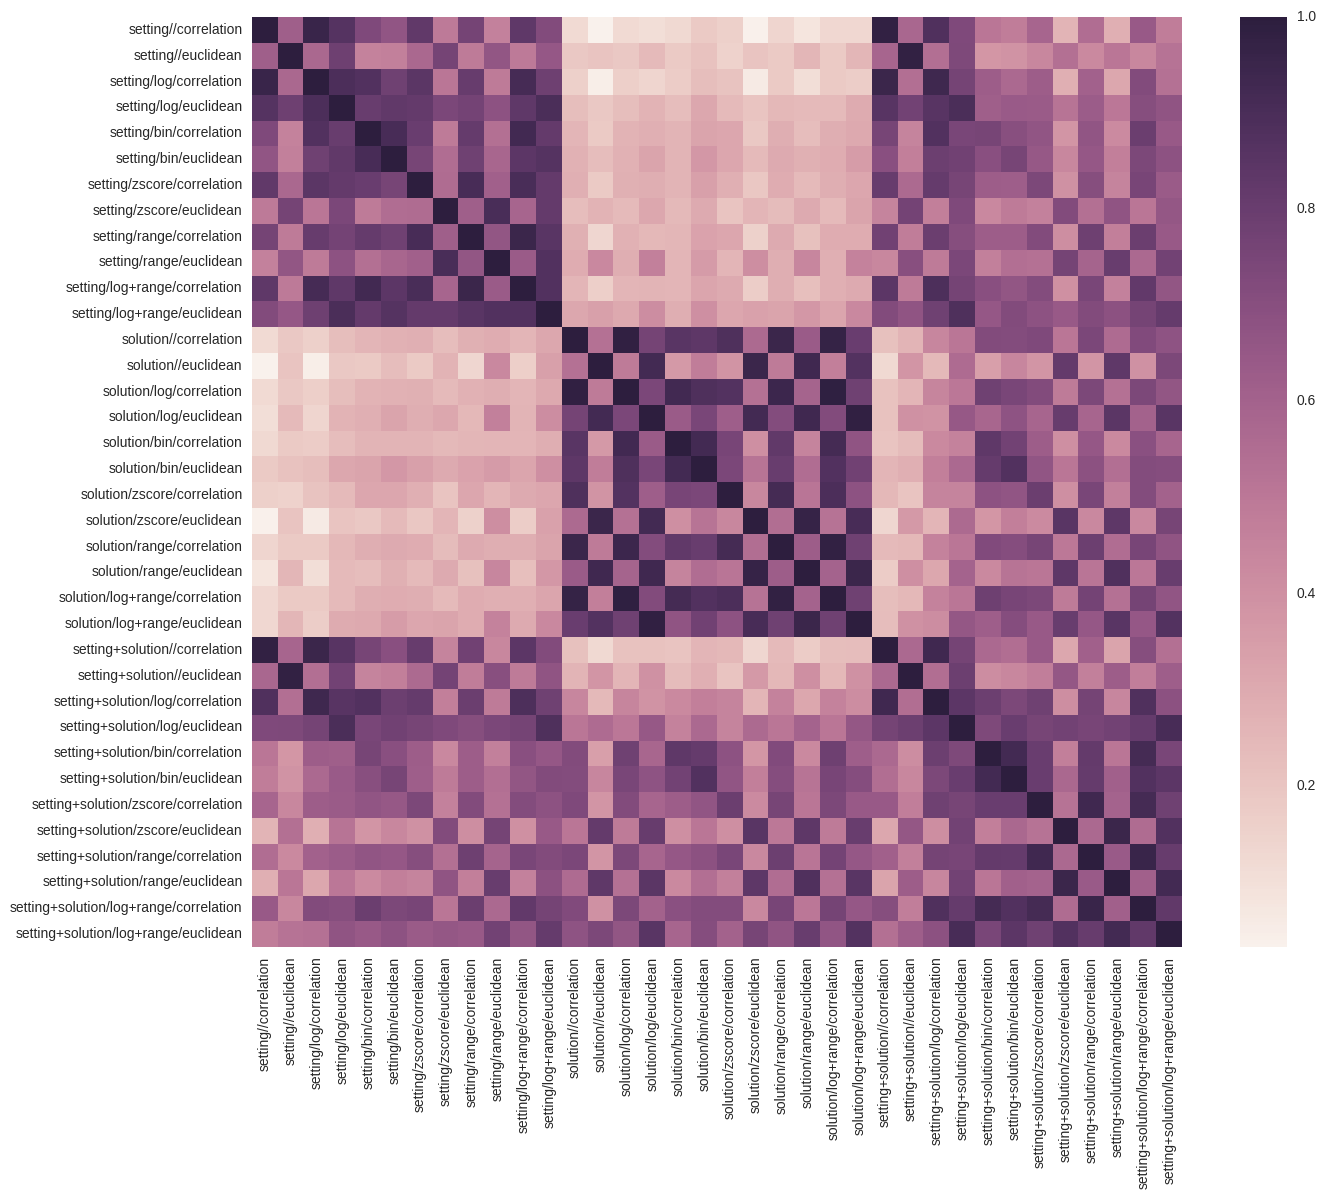

In [11]:
def compute_agreement(df, metric='pearson'):
    if metric == 'pearson':
        return df.corr()
    raise ValueError('Unknown metric for computing agreement between vectors of similarities.')

plt.figure(figsize=(15, 12))
sns.heatmap(compute_agreement(similarities), annot=False)

# PCA

In [12]:
def create_model(name):
    if name == 'pca':
        return PCA(n_components=2)
    if name == 'tsne':
        return TSNE(perplexity=30, learning_rate=200, n_iter=5000)
    raise ValueError('Unknown model name "{name}"'.format(name=name))
    
def project(features, model='pca', label=''):    
    title = '{label} ({model})'.format(label=label, model=model)
    model = create_model(name=model)
    emb = pd.DataFrame(model.fit_transform(features))                       
    plt.figure(figsize=(10, 10))
    n = len(emb)
    x = emb[0] + np.random.normal(scale=0.01, size=n)
    y = emb[1] + np.random.normal(scale=0.01, size=n)
    colors = [get_level(task, norm=True) for task in tasks]
    plt.scatter(x, y, c=colors, cmap=plt.get_cmap('viridis'))
    labels = [plt.text(x[i], y[i], tasks[i].task_id, size=8) for i in range(n)]
    adjust_text(labels)
    plt.title(title)
    plt.show()
    return model

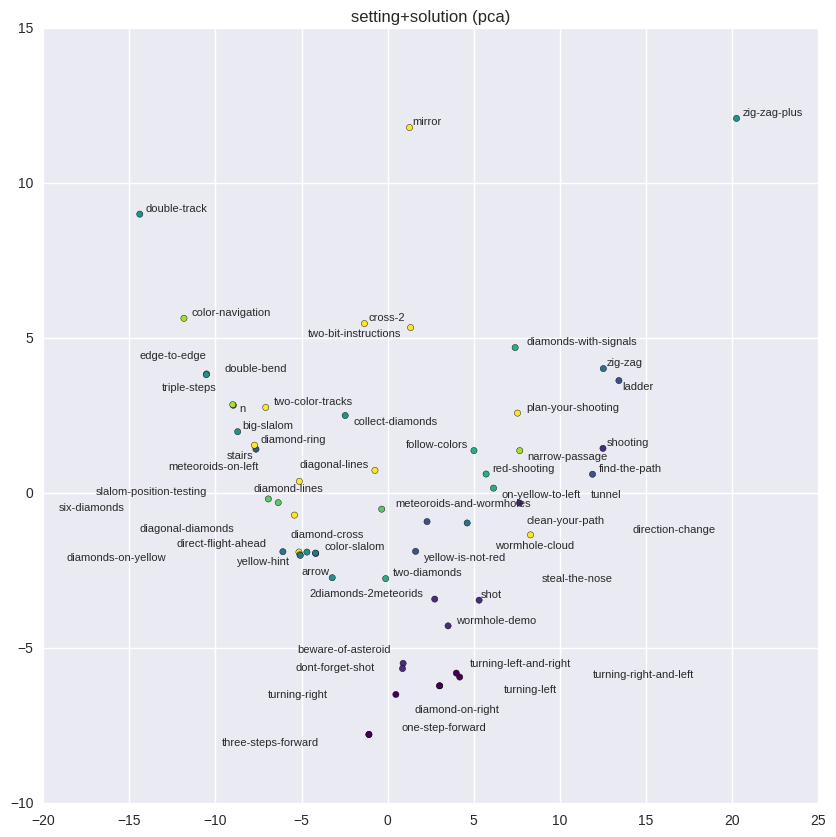

In [13]:
features = get_feature_df(which_features='setting+solution', transform='bin')
model = project(setting_features, model='pca', label='setting+solution')

# Setting vs Solution Features

Let us explore the relationship between setting and solution features in another 2D projection. This time, we compute the main component for setting features and the main component for solution features separately, and project all tasks separately to these two components.

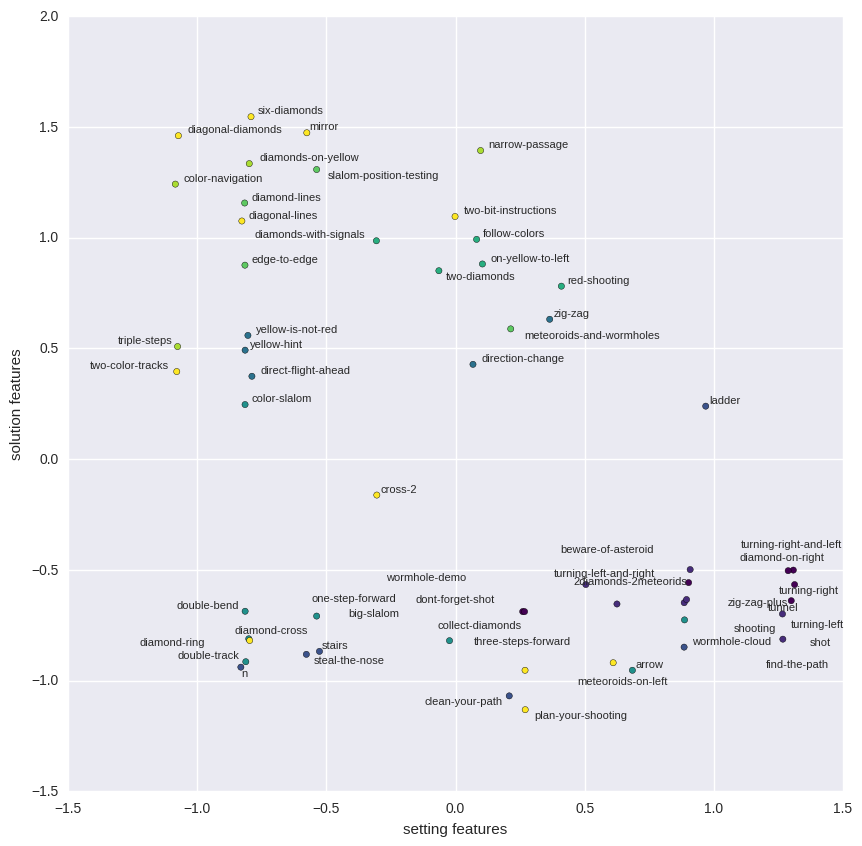

In [14]:
setting_features = get_feature_df(which_features='setting', transform='bin')
setting_model = PCA(n_components=1)
setting_emb = setting_model.fit_transform(setting_features)
solution_features = get_feature_df(which_features='solution', transform='bin')
solution_model = PCA(n_components=1)
solution_emb = solution_model.fit_transform(solution_features)
emb = pd.DataFrame({'x': setting_emb.flatten(), 'y': solution_emb.flatten()})
n = len(emb)
x = emb.x + np.random.normal(scale=0.01, size=n)
y = emb.y + np.random.normal(scale=0.01, size=n)
colors = [get_level(task, norm=True) for task in tasks]
plt.figure(figsize=(10, 10))
plt.scatter(x, y, c=colors, cmap=plt.get_cmap('viridis'))
labels = [plt.text(x[i], y[i], tasks[i].task_id, size=8) for i in range(n)]
adjust_text(labels)
plt.xlabel('setting features')
plt.ylabel('solution features')
plt.show()

To better understand semantics of each axis, let us plot strengths of original features in the main components. From these barplots (see below), we can see that x-axis corresponds roughly to "diamonds + wormholes + colors - stones" and y-axis corresponds approximately to "tests - repeat".

In [15]:
def show_main_component(features):
    model = PCA(n_components=1)
    emb = model.fit_transform(features)
    df = pd.DataFrame({'feature': features.columns, 'strength': model.components_[0]})
    df = df.sort_values(by='strength')
    ax = sns.barplot(df.feature, df.strength, palette="RdBu_r")
    ax.set(ylabel='strength')

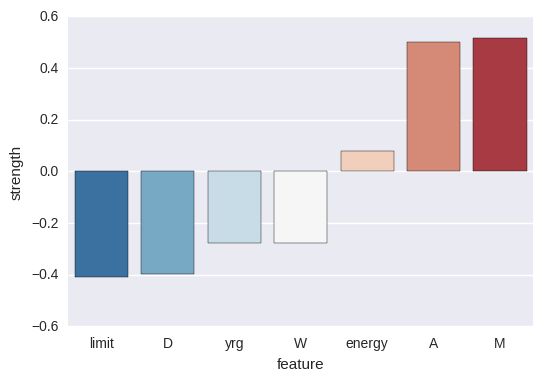

In [16]:
show_main_component(setting_features)

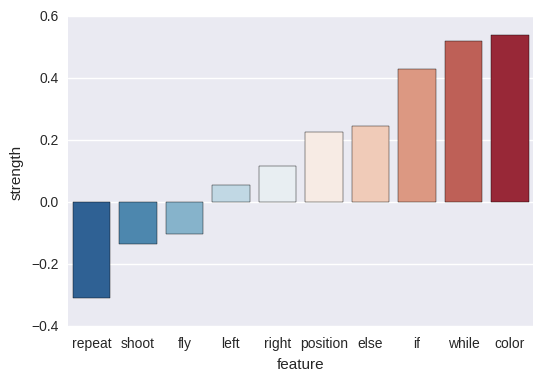

In [17]:
show_main_component(solution_features)

# Feature Correlations

Let us explore correlations between pair of features. It can help us to find "holes" in current task space. For example, if there are two features with negative correlation, we can ask if this relationship is really enforced by the game constraints. If not, we can try to create new tasks with both of these features to enrich our task space.

In [18]:
def show_correlation(features):
    corr = features.corr()
    sns.clustermap(corr)

Let us start with setting features only. See the heatmap below, which also shows a hirearchical clustering of features based on the strenght of the correlation.

We can obsere natural correlation between some setting features, for example red color with yellow color,  asteroids with meteoroids, and "additional" wormholes (X, Y, Z).

Looking at the pairs with negative correlation, diamonds tend to avoid tasks with asteorids or meteoroids. Diamonds and stones both serve to enforce a path and tasks with both diamonds and stones can become too cluttered and confusing, so it seems natual to only use one of these game elements.

There is also slight negative colorrelation bettwen colors and stones. Colors and stones have different primary purpose (colors servers for making decisions, stones for enforcing path), but having both in a single tasks is often not necessary, becasue path can be also constrained by the presence of diamonds instead of stones. Similarly as in the previous case, worlds with both colors and stones can easily become too cluttered.

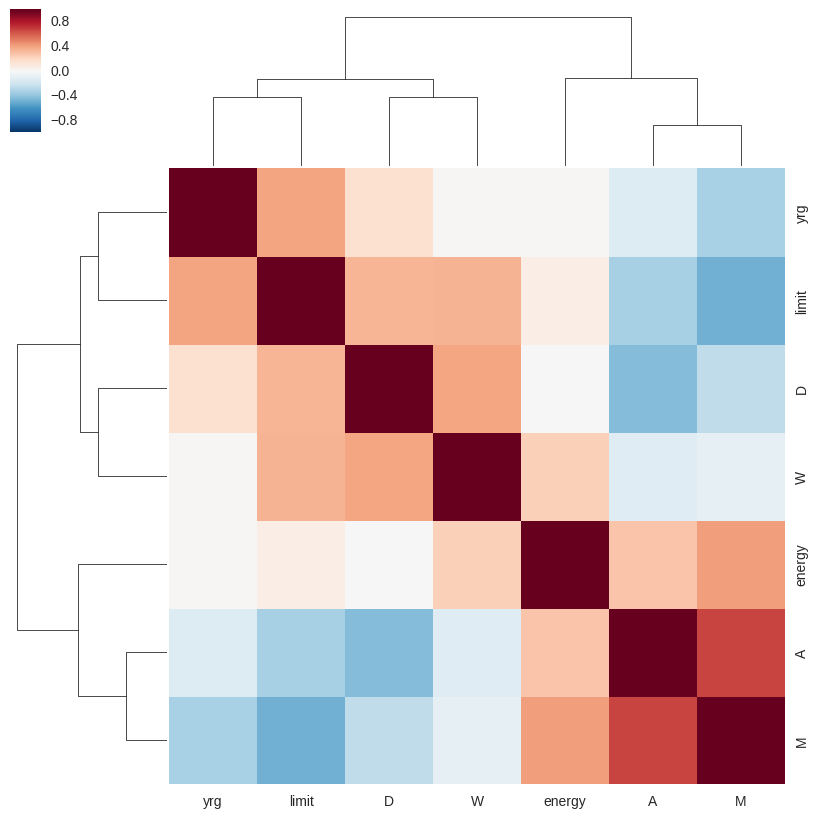

In [21]:
show_correlation(setting_features)

Now let us look at the solution features. Again, there are some natural high-correlation pairs, such as while-color, if-color and if-else. There are also some natural high-negative-correlation pairs, e.g. repeat with tests. There is also a strong negative correlation between while and repeat loops, which is partially enforced by the necessity to have some introductory while/repeat tasks containing only a single loop. Tasks with both loops are certainly possible, they are just more difficult to create, because both nested loops or two loops in a sequence require longer path.

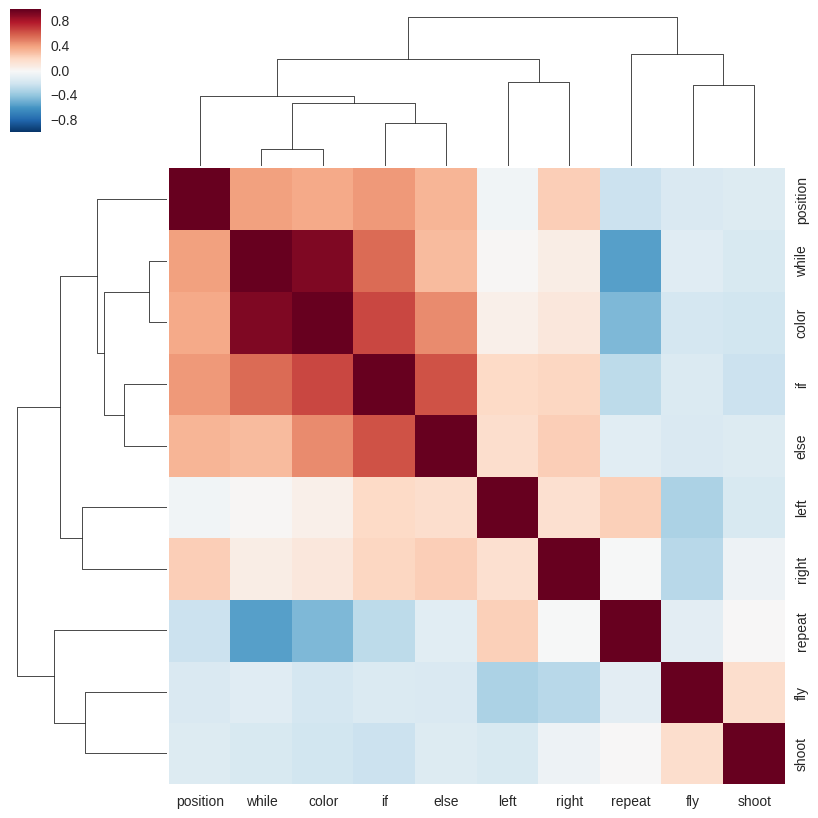

In [22]:
show_correlation(solution_features)

Finally, let us plot correlations between both setting and solution features. There are some new pairs with negative correlations:
* colors (red, yellow) with repeat loop (probably natural; you don't need colors with a repeat loop)
* color-test with stones (consequence of already mentioned colors-stones anti-correlation)
* if/while with stones (this is similar as the previous point, but it suggests we could create new tasks with stones and positional test - note that there is also slight negative correlation between position and stones, for which I can see any inherent need)


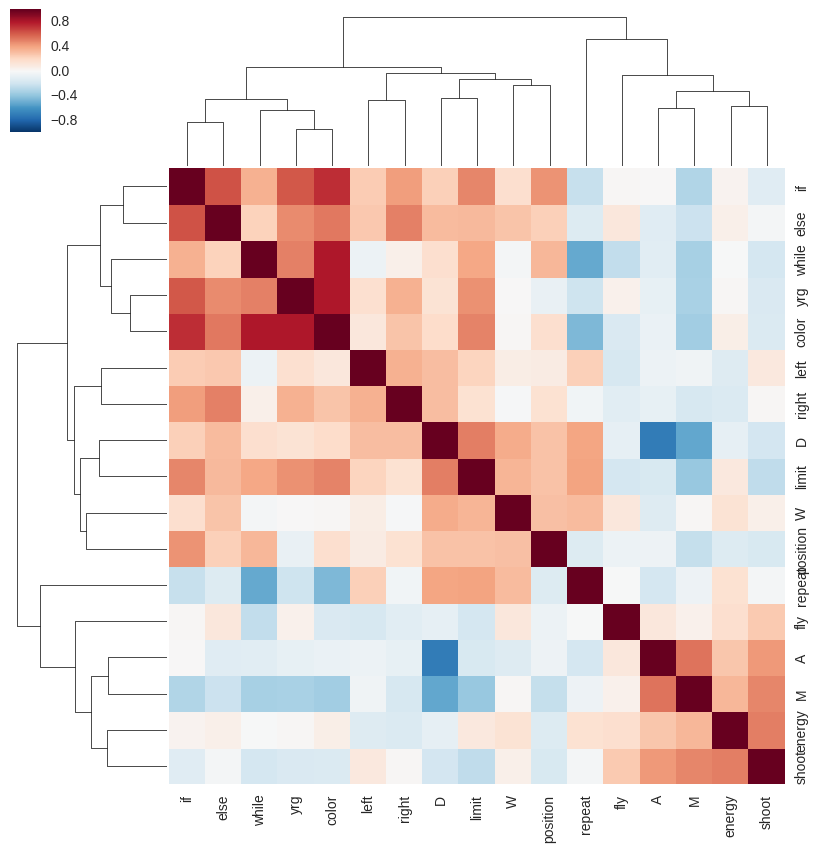

In [23]:
show_correlation(all_features)